## Load packages

In [1]:
# add Cuba HypergeometricFunctions SpecialFunctions BenchmarkTools Interpolations Distributions KernelDensity DelimitedFiles StatsPlots NestedSamplers StatsBase Random MCMCChains AbstractMCMC BAT IntervalSets

model = "GWTC3_powerlaw"
include("events.jl")
include("utils.jl")
# using HypergeometricFunctions
# using SpecialFunctions
# using Distributions
# using KernelDensity
# using Random
# using MCMCChains
# using Roots

reduce_post (generic function with 1 method)

In [116]:
posts0 = [get_post(event) for event in GWTC3_events_BBH];
posts = [reduce_post(post, 100) for post in posts0];

In [117]:
pdraws0 = readdlm("/home/czc/projects/working/LIGO_posterior/GWTC-3/GWTC-3_pdraw_m1_m2_z.txt");
n_draw0 = size(pdraws0)[1];
pdraws = pdraws0[rand(1:n_draw0, 1000), :]
n_draw = size(pdraws)[1];

In [118]:
h, ΩM = 0.6736, 0.315
lcdm = LCDM(h, ΩM);


In [146]:
t0, tz, DLz, HH = lcdm.t0, lcdm.tz, lcdm.DLz, lcdm.HH;

In [149]:
z_factor0(z) = (tz(z) / t0)^(-34 / 37) 
z_factor(z) = (tz(z) / t0)^(-34 / 37) / HH(z) /(1+z)

z_factor (generic function with 1 method)

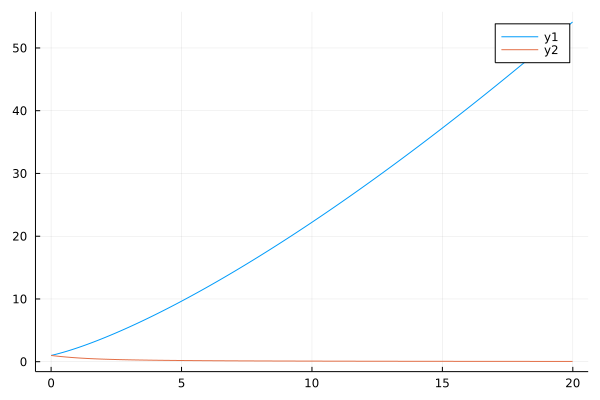

In [152]:
zs = 1e-10:0.01:20
plot(zs, z_factor0.(zs))
plot!(zs, z_factor.(zs))

In [119]:
f = 0.0025693801260000975
M = 8.896735628637506;
α = 1.9108320383237213;
log_fpbh = log10(f)
i = 10
j = 30
z = 1e-10;

## Merger rate 

In [120]:
function mergerRateDensity1st(i, j, M, α, f)
    denominator = 4.884e7 * (i + j)^(36 / 37) * (i / M)^(-α) * (j / M)^(-α) * ((f * (-1 + α)) / (M * α))^(53 / 37) * α^3
    numerator = (i * j)^(34 / 37) * M^(21 / 37) * (21 + 37 * α)
    denominator / numerator
end
mergerRateDensity1st(i, j, M, α, f)

0.04755480497210485

In [121]:
# function beta_func(x, y, a, b)
#     δ = y - x
#     int0(t) = t^(a-1) * (1-t)^(b-1)
#     int(t) = δ * int0(x + δ*t)
#     function integrand(x, f)
#         f[1] = int(x[1])
#     end
#     result, err = cuhre(integrand, rtol=1e-1)
#     result[1]
# end

function beta_func2(x, y, a, b)
    int0(t) = t^(a - 1) * (1 - t)^(b - 1)

    vx = range(x, y, length=20)
    M = [int0(e) for e = vx]
    # @show M
    result = trapz((vx), M)
end

beta_func2 (generic function with 1 method)

In [122]:
function mergerRateDensity2nd0(i, j, M, α, fpbh)
  if i > 2 * M
    5.883e5 * fpbh^(69 / 37) * i^(-2α) * j^(-α) * (i + j)^(72 / 37) * M^(-3 + 3α) * α^4 * beta_func2(M / i, 1 - M / i, -α, -α) * ((α - 1) / α)^(69 / 37) / (i * j)^(31 / 37) / (42 + 37α)
  else
    1e-80
  end
end

mergerRateDensity2nd(i, j, M, α, f) = 0.5 * (mergerRateDensity2nd0(i, j, M, α, f) + mergerRateDensity2nd0(j, i, M, α, f))

mergerRateDensity2nd (generic function with 1 method)

In [134]:
# function mergerRateDensity(i, j, M, α, f, z)
#   if (i > M) & (j > M)
#     (tz(z) / t0)^(-34 / 37) * mergerRateDensity1st(i, j, M, α, f) + (tz(z) / t0)^(-31 / 37) * mergerRateDensity2nd(i, j, M, α, f)
#   else
#     1e-80
#   end
# end
function mergerRateDensity(i, j, M, α, f, z)
  if (i > M) & (j > M)
    (tz(z) / t0)^(-34 / 37) * mergerRateDensity1st(i, j, M, α, f) 
  else
    1e-80
  end
end

# mergerRateDensity(i, j, M, α, f, z) = (tz(z) / t0)^(-34 / 37) * mergerRateDensity1st(i, j, M, α, f) + (tz(z) / t0)^(-31 / 37) * mergerRateDensity2nd(i, j, M, α, f)
mergerRateDensity(i, j, M, α, f, z)

0.04755480497210485

In [135]:
function merger_rate(M, α, f, z)
    m_min = M
    m_max = 150
    δm = m_max - m_min
    int(m1, m2) = δm^2 * mergerRateDensity(m_min + δm * m1, m_min + δm * m2, M, α, f, z)
    function integrand(x, f)
        f[1] = int(x[1], x[2])
    end
    result, err = cuhre(integrand, rtol=1e-3)
    0.5 * result[1]
end

merger_rate(M, α, f, z)

21.510038040096248

## Likelihood

In [136]:
# selection effect
function β_func(M, α, fpbh)
    β = 0.0
    for pdraw in eachrow(pdraws)
        m1, m2, z, pθ = pdraw
        β += mergerRateDensity(m1, m2, M, α, fpbh, z) / pθ
        # β += mergerRateDensity1st(m1, m2, M, α, fpbh) / pθ
    end
    N_generated = 73280198 # number of generated injection for GWTC-3
    β / N_generated * n_draw0 / n_draw
end

β_func(M, α, 1e-3)

14.596478980799482

In [137]:
@time β_func(M, α, 1e-3)

14.596478980799482

In [138]:
β_func(M, α, 1e-1), β_func(M, α, 1e-3), β_func(M, α, 1e-5)

(10693.330038700718, 14.596478980799482, 0.019924307756876085)

In [139]:
# log(single_event_posterior * merger_rate_density)
function log_pR_func(M, α, fpbh, post)
    result = 0.0
    for p in eachrow(post)
        m1, m2, z, DL = p
        result += mergerRateDensity(m1, m2, M, α, fpbh, z) / DL^2
        # result += mergerRateDensity1st(m1, m2, M, α, fpbh) #/ DL^2
    end
    log(result / size(post)[1])
end

log_pR_func (generic function with 1 method)

In [140]:
function logL(M, α, log_fpbh, posts)
    fpbh = 10.0^log_fpbh
    -β_func(M, α, fpbh) + sum(log_pR_func.(M, α, fpbh, posts))
end

logL (generic function with 1 method)

In [141]:
@time logL(M, α, -3, posts)

-1762.2925764754066

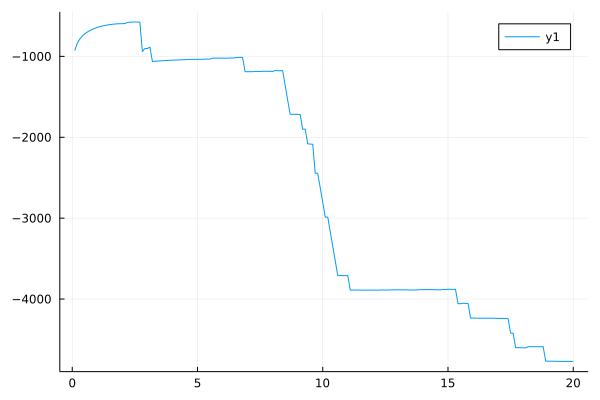

In [145]:
xs = 1e-1:0.1:20
lls = [logL(x, α, log_fpbh, posts) for x in xs]
plot(xs, lls)

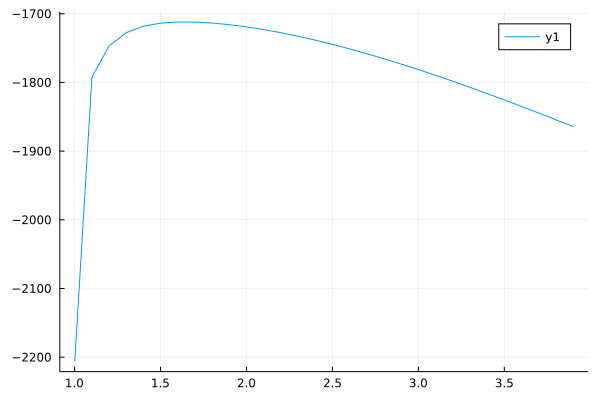

In [143]:
xs = 1.001:0.1:4
lls = [logL(M, x, log_fpbh, posts) for x in xs]
plot(xs, lls)

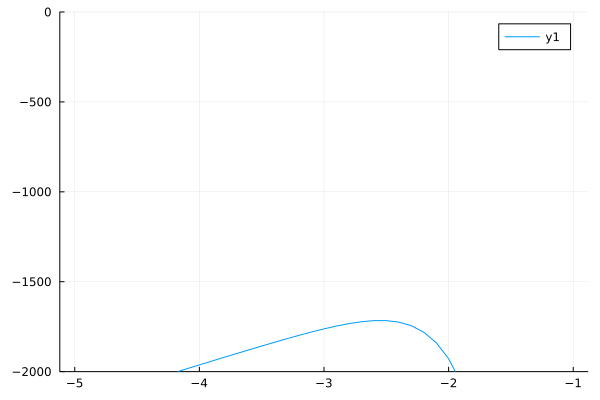

In [144]:
xs = -5:0.1:-1
lls = [logL(M, α, x, posts) for x in xs]
plot(xs, lls, ylim=(-2e3, 1))

## Sampling

In [45]:
likelihood = ps -> LogDVal(logL(ps.M, ps.α, ps.log_fpbh, posts))

prior = BAT.NamedTupleDist(
    M=(1) .. (20),
    α=(1.01) .. (4.0),
    log_fpbh=(-4) .. (-0.0)
)

posterior = PosteriorDensity(likelihood, prior);

In [47]:
true_par_values = (M=M, α=α, log_fpbh=-3)
@time likelihood(true_par_values)

  0.067642 seconds (260.45 k allocations: 9.191 MiB)


LogDVal{Float64}(-1036.0178826262786)

In [50]:
@time begin
    println("Start sampling.")

    burnin = MCMCMultiCycleBurnin(max_ncycles=1000)
    samples, chains = bat_sample(posterior, MCMCSampling(mcalg=MetropolisHastings(), nsteps=10^4, nchains=4, burnin=burnin))
end

save("backup/samples_$model.jld2", Dict("samples" => samples, "chains" => chains))
println(" ")
println("Finish sampling and save samples.")

Start sampling.
10634.455327 seconds (129.35 G allocations: 4.625 TiB, 9.18% gc time, 0.11% compilation time)
 
Finish sampling and save samples.


┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64, 10}
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Using transform algorithm PriorSubstitution()
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:56
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/chain_pool_init.jl:173
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:35
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 4 converged.
└ @ BAT /home/czc/.julia/packages/BAT/XvOy6/src/samplers/mcmc/multi_cycle_burnin.jl:65
┌ Info: MCMC Tuning cycle 3 fi

In [51]:
samples = load("backup/samples_$model.jld2")["samples"];

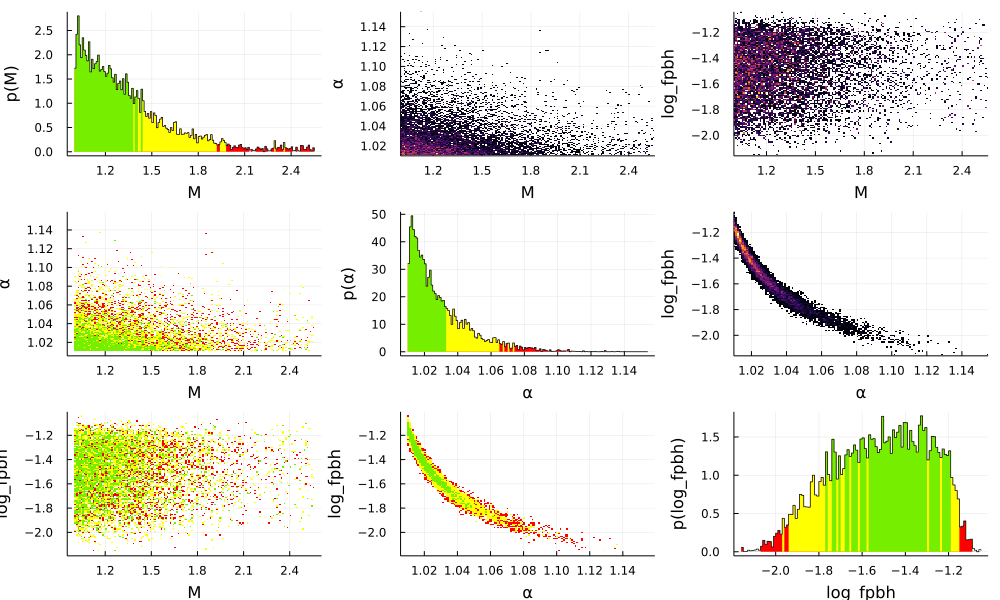

In [53]:
plot(samples)

In [19]:
# plot(
#     samples, :log_p3,
#     mean = true, std = true, globalmode = true, marginalmode = true,
#     nbins = 50, title = "Marginalized Distribution for y"
# )

In [20]:
sd = SampledDensity(posterior, samples)
display(sd)

BAT.jl - SampledDensity
──────────────────────────────

Sampling:
─────────────────────────
total number of samples:      918
effective number of samples: (mc = 201.80969763172732, σc = 146.08103984858695, log_fpbh = 189.90892499799085)


Parameter estimates:
─────────────────────────
number of free parameters: 3

NamedTuple{(:parameter, :mean, :std, :global_mode, :marginal_mode), Tuple{Symbol, Float64, Float64, Float64, Float64}}[(parameter = :mc, mean = 16.99085761567653, std = 2.2122642835181123, global_mode = 16.754656023930146, marginal_mode = 16.35), (parameter = :σc, mean = 0.8407914207087999, std = 0.0853291473539181, global_mode = 0.8008363441722768, marginal_mode = 0.8875), (parameter = :log_fpbh, mean = -2.5318046043473985, std = 0.06491226694644411, global_mode = -2.492530718392467, marginal_mode = -2.559)]


Covariance matrix:
─────────────────────────
3×3 Named Matrix{Float64}
  cov ╲  │          mc           σc     log_fpbh
─────────┼─────────────────────────────────────